In [79]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
from shapely.geometry import box
import supervision as sv
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import random
import seaborn as sns
from pathlib import Path
import matplotlib.patches as patches
from tqdm import tqdm

In [3]:
from ultralytics import YOLO

In [4]:
random.seed(0)

In [5]:
torch.cuda.is_available()

True

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/SRIP 2025")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pwd

/content


In [10]:
os.chdir("/content/drive/MyDrive/SRIP 2025")
!pwd

/content/drive/MyDrive/SRIP 2025


### Data Exploration and Understanding

### 1

#### Only counting category 0 and category 1 as solar panels. The bounding boxes associated with category 2 are of low confidence. Hence we can get a lower bound on the number of solar panels. To get an upper bound on the number of panels even category 2 can be included.

#### There are cases where a same solar panel is present in multiple images. In such cases the solar panel is being counted multiples times.

In [11]:
labels_path = './datasets/data/labels/labels_native'
total_instances_lower = 0
total_instances_upper = 0
labels_per_image = {}
for file_name in os.listdir(labels_path):
    file_path = os.path.join(labels_path, file_name)
    label = 0
    with open(file_path, 'r') as file:
        for line in file:
            total_instances_upper += 1
            if line[0] == '0' or line[0] == '1':
                total_instances_lower += 1
            label += 1
    if label in labels_per_image:
        labels_per_image[label] += 1
    else:
        labels_per_image[label] = 1

In [12]:
total_instances_lower, total_instances_upper

(29397, 29625)

#### Therefore there are somewhere between 29397 to 29625 solar panels in the dataset.

In [13]:
for key, value in labels_per_image.items():
    print(f'{value} images have {key} labels')

167 images have 2 labels
49 images have 14 labels
25 images have 18 labels
218 images have 4 labels
217 images have 5 labels
170 images have 7 labels
4 images have 66 labels
84 images have 12 labels
221 images have 3 labels
69 images have 13 labels
184 images have 8 labels
16 images have 52 labels
14 images have 20 labels
189 images have 6 labels
121 images have 10 labels
19 images have 34 labels
29 images have 19 labels
36 images have 17 labels
169 images have 9 labels
46 images have 15 labels
10 images have 35 labels
5 images have 27 labels
97 images have 11 labels
9 images have 47 labels
4 images have 23 labels
9 images have 51 labels
17 images have 37 labels
9 images have 40 labels
10 images have 41 labels
15 images have 29 labels
41 images have 16 labels
13 images have 38 labels
20 images have 30 labels
4 images have 25 labels
13 images have 33 labels
81 images have 1 labels
1 images have 56 labels
6 images have 62 labels
6 images have 50 labels
11 images have 43 labels
8 images h

#### The number of unique solar panels is given below, this is from https://www.nature.com/articles/s41597-023-02539-8

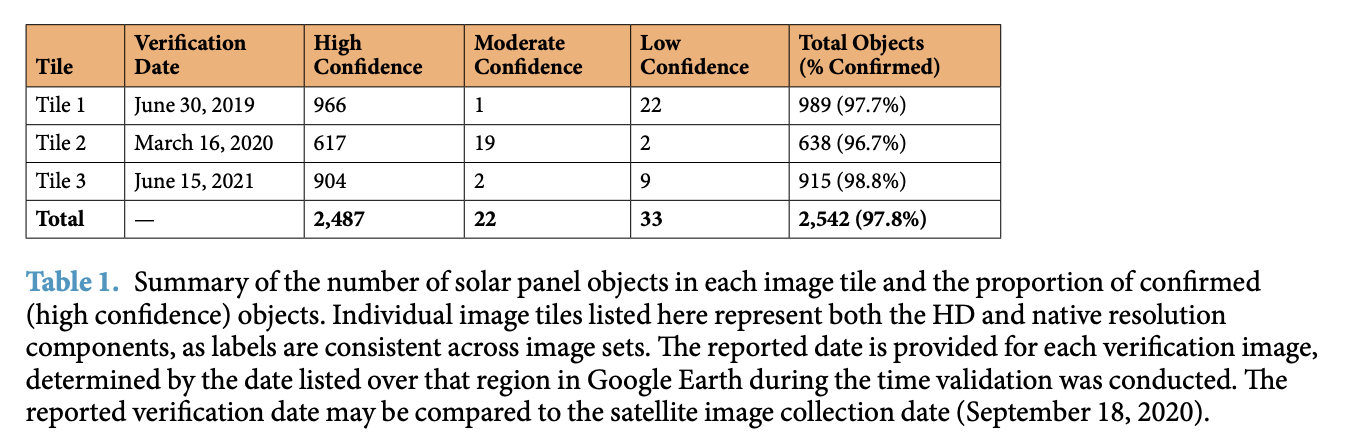

In [14]:
from IPython.display import display
from PIL import Image

image_path = "data_understanding.png"
img = Image.open(image_path)
display(img)

### 2

In [15]:
def get_area(x_width, y_width):
    de_norm_x = x_width * 416
    de_norm_y = y_width * 416

    # 0.31 is the scaling factor mentioned in the label readme
    x_width_actual = de_norm_x * 0.31
    y_width_actual = de_norm_y * 0.31

    area = x_width_actual * y_width_actual

    return area

#### The width and height are first denormalized. Then they are scaled according to the parameter given in label readme. Then area is calculated using l*b.

In [16]:
areas_list = []
labels_path = './datasets/data/labels/labels_native'
for file_name in os.listdir(labels_path):
    file_path = os.path.join(labels_path, file_name)
    with open(file_path, 'r') as file:
        for line in file:
            line = line.split()
            x_width = float(line[3])
            y_width = float(line[4])
            area = get_area(x_width, y_width)
            areas_list.append(area)

In [17]:
areas_list = np.array(areas_list)
mean = np.mean(areas_list)
std = np.std(areas_list)

In [18]:
max(areas_list), min(areas_list)

(12177.407600000002, 1.0571000000000002)

In [19]:
print(f'Mean: {mean}, Std: {std}')

Mean: 191.51782786497893, Std: 630.7003355500087


#### The mean area of solar panels is 190.51 sq.m and the standard deviation is 630.70 sq.q

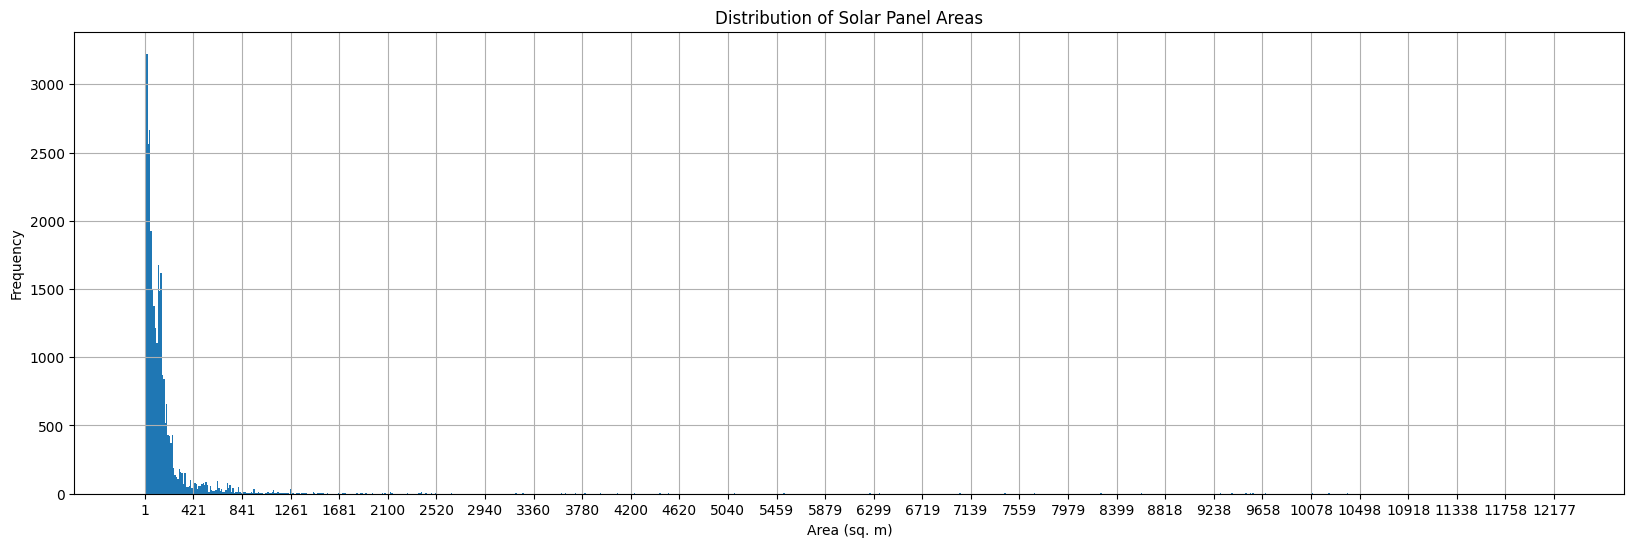

In [20]:
plt.figure(figsize=(20, 6))
plt.hist(areas_list, bins=1000)
plt.xticks(np.linspace(min(areas_list), max(areas_list), 30))
plt.xlabel("Area (sq. m)")
plt.ylabel("Frequency")
plt.title("Distribution of Solar Panel Areas")
plt.grid(True)
plt.show()

#### The above histogram tells us that majority of solar panels have area less than 420 sq.m. And there are also a few outlier solar panels with area as high as 12,000 sq.m

### Implementing the Fundamental Functions

### 1

In [21]:
def convert_yolo_corner(x_center, y_center, x_width, y_width, img_width, img_height):

    x_min = (x_center - x_width / 2) * img_width
    y_min = (y_center - y_width / 2) * img_height
    x_max = (x_center + x_width / 2) * img_width
    y_max = (y_center + y_width / 2) * img_height

    return x_min, y_min, x_max, y_max

In [22]:
def get_iou(x_center_1, y_center_1, x_width_1, y_width_1, x_center_2, y_center_2, x_width_2, y_width_2, img_width, img_height):

    x1_min, y1_min, x1_max, y1_max = convert_yolo_corner(x_center_1, y_center_1, x_width_1, y_width_1, img_width, img_height)
    x2_min, y2_min, x2_max, y2_max = convert_yolo_corner(x_center_2, y_center_2, x_width_2, y_width_2, img_width, img_height)

    # covert to xyxy format as required by shapely.box
    bounding_box_1 = box(x1_min, y1_min, x1_max, y1_max)
    bounding_box_2 = box(x2_min, y2_min, x2_max, y2_max)

    area_of_intersection = bounding_box_1.intersection(bounding_box_2).area
    area_of_union = bounding_box_1.union(bounding_box_2).area

    iou = area_of_intersection / area_of_union if area_of_union != 0 else 0
    return iou

In [23]:
a = np.array([0.5, 0.5, 0.5, 0.5])

In [24]:
a[np.newaxis, :].shape

(1, 4)

In [25]:
img_width = 416
img_height = 416

sample_iou = get_iou(0.5, 0.5, 0.4, 0.4, 0.6, 0.6, 0.3, 0.3, img_width, img_height)

bounding_box_absolute_1 = np.array(convert_yolo_corner(0.5, 0.5, 0.4, 0.4, img_width, img_height))
bounding_box_absolute_2 = np.array(convert_yolo_corner(0.6, 0.6, 0.3, 0.3, img_width, img_height))

iou_supervision = sv.detection.utils.box_iou_batch(bounding_box_absolute_1[np.newaxis, :], bounding_box_absolute_2[np.newaxis, :])

print("IOU implemented ", sample_iou)
print("IOU Supervision ", iou_supervision[0][0])

IOU implemented  0.3333333333333333
IOU Supervision  0.3333333333333334


### 2

In [26]:
def get_iou_xyxy(box1, box2):
    bounding_box_1 = box(box1[0], box1[1], box2[2], box1[3])
    bounding_box_2 = box(box2[0], box2[1], box2[2], box2[3])

    area_of_intersection = bounding_box_1.intersection(bounding_box_2).area
    area_of_union = bounding_box_1.union(bounding_box_2).area

    iou = area_of_intersection / area_of_union if area_of_union != 0 else 0
    return iou

#### 2.a

In [27]:
def get_11_pt_ap(precision, recalls):
    if len(precision) == 0 or len(recalls) == 0:
        return 0.0

    # Sort the pairs according to recall
    indices = np.argsort(recalls)
    sorted_recall = np.array(recalls[indices])
    sorted_precision = np.array(precision[indices])

    # 11-point interpolation
    ap = 0.0

    for t in np.linspace(0.0, 1.0, 11):
        p = np.max(sorted_precision[sorted_recall >= t]) if np.sum(sorted_recall >= t) > 0 else 0.0
        ap += p / 11.0

    return ap

#### 2.b

In [28]:
def get_101_pt_ap(precisions, recalls):
    if len(precisions) == 0 or len(recalls) == 0:
        return 0.0

    # Sort the pairs according to recall
    indices = np.argsort(recalls)
    sorted_recall = np.array(recalls[indices])
    sorted_precision = np.array(precisions[indices])

    # 101-point interpolation
    ap = 0.0
    for t in np.linspace(0.0, 1.0, 101):
        p = np.max(sorted_precision[sorted_recall >= t]) if np.sum(sorted_recall >= t) > 0 else 0.0
        ap += p / 101.0

    return ap

#### 2.c

In [29]:
def compute_ap_auc(precisions, recalls):
    if len(precisions) == 0 or len(recalls) == 0:
        return 0.0

    # Sort the pairs according to recall
    indices = np.argsort(recalls)
    sorted_recalls = np.array(recalls)[indices]
    sorted_precisions = np.array(precisions)[indices]

    # Make sure precision are in decreasing order
    for i in range(len(sorted_precisions) - 2, -1, -1):
        sorted_precisions[i] = max(sorted_precisions[i], sorted_precisions[i + 1])

    # Compute area under the curve using the trapezoidal rule
    ap = 0.0
    for i in range(len(sorted_recalls) - 1):
        dx = sorted_recalls[i + 1] - sorted_recalls[i]
        f_x = (sorted_precisions[i] + sorted_precisions[i + 1]) / 2.0
        ap += f_x * dx

    return ap

#### 2.d

##### Depending on our assumption, the question can have two answers.
##### If we assume the pred_boxes and gt_boxes correspond to each other (i.e pred_boxes[i] is the prediction for gt_boxes[i]), then this is case_1.
##### However if we follow standard approach in object detections and pair up the most overlapping gt_box for each pred_box, then this is case_2. (We need to ensure that each gt_box is paired up with atmost one pred_box)
##### both of the cases are described below
##### the answer in case_2 will be significantly higher than the answer in case_1 beacause the boxes are of 20x20 and image is of 100x100 lots of pred_boxes will overlap with some or the other gt_box with iou >= 50

In [30]:
def generate_random_boxes(n_boxes, box_size, image_size):
    boxes = []
    for _ in range(n_boxes):
        # this is to ensure the box stays inside the image
        x1 = random.randint(0, image_size - box_size)
        y1 = random.randint(0, image_size - box_size)
        x2 = x1 + box_size
        y2 = y1 + box_size
        boxes.append([x1, y1, x2, y2])
    return boxes

In [31]:
def get_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    # Sort predictions by confidence score (highest first)
    sorted_indices = np.argsort(pred_scores)[::-1]
    sorted_pred_boxes = [pred_boxes[i] for i in sorted_indices]

    # Initialize variables
    n_gt = len(gt_boxes)
    tp = np.zeros(len(sorted_pred_boxes))
    fp = np.zeros(len(sorted_pred_boxes))

    # Evaluate each prediction
    for i, pred_box in enumerate(sorted_pred_boxes):
        # Find the corresponding ground truth box index
        gt_idx = sorted_indices[i]

        # Calculate IoU with the corresponding ground truth box
        iou = get_iou_xyxy(pred_box, gt_boxes[gt_idx])

        # Assign as true positive or false positive
        if iou >= iou_threshold:
            tp[i] = 1
        else:
            fp[i] = 1


    # Compute precision and recall
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    recalls = tp_cumsum / n_gt

    return precisions, recalls

In [32]:
def get_precision_recall_best_match(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    # Sort predictions by confidence score (highest first)
    sorted_indices = np.argsort(pred_scores)[::-1]
    sorted_pred_boxes = [pred_boxes[i] for i in sorted_indices]

    # Initialize variables
    n_gt = len(gt_boxes)
    tp = np.zeros(len(sorted_pred_boxes))
    fp = np.zeros(len(sorted_pred_boxes))
    # this is to ensure, each ground truth box is matched at most once
    gt_matched = [False] * n_gt

    # Evaluate each prediction
    for i, pred_box in enumerate(sorted_pred_boxes):
        # Find the best matching ground truth box
        max_iou = 0.0
        best_gt_idx = -1

        for j, gt_box in enumerate(gt_boxes):
            if not gt_matched[j]:
                iou = get_iou_xyxy(pred_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    best_gt_idx = j

        # Assign as true positive or false positive
        if max_iou >= iou_threshold and best_gt_idx != -1:
            tp[i] = 1
            gt_matched[best_gt_idx] = True
        else:
            fp[i] = 1

    # Compute precision and recall
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    recalls = tp_cumsum / n_gt

    return precisions, recalls

In [33]:
def compute_ap_metrics(total_gt_boxes, total_pred_boxes, total_pred_scores, iou_threshold=0.5):
    # Flatten all boxes and scores across images
    gt_boxes_flat = []
    pred_boxes_flat = []
    pred_scores_flat = []

    for i in range(len(total_gt_boxes)):
        gt_boxes_flat.extend(total_gt_boxes[i])
        pred_boxes_flat.extend(total_pred_boxes[i])
        pred_scores_flat.extend(total_pred_scores[i])

    # Compute precision and recall
    precisions, recalls = get_precision_recall(gt_boxes_flat, pred_boxes_flat, pred_scores_flat, iou_threshold)

    # Compute AP using three different methods
    ap_pascal = get_11_pt_ap(precisions, recalls)
    ap_coco = get_101_pt_ap(precisions, recalls)
    ap_auc = compute_ap_auc(precisions, recalls)

    return {
        "pascal_voc": ap_pascal,
        "coco": ap_coco,
        "auc": ap_auc
    }

In [34]:
def compute_ap_metrics_best_match(total_gt_boxes, total_pred_boxes, total_pred_scores, iou_threshold=0.5):
    # Flatten all boxes and scores across images
    gt_boxes_flat = []
    pred_boxes_flat = []
    pred_scores_flat = []

    for i in range(len(total_gt_boxes)):
        gt_boxes_flat.extend(total_gt_boxes[i])
        pred_boxes_flat.extend(total_pred_boxes[i])
        pred_scores_flat.extend(total_pred_scores[i])

    # Compute precision and recall
    precisions, recalls = get_precision_recall_best_match(gt_boxes_flat, pred_boxes_flat, pred_scores_flat, iou_threshold)

    # Compute AP using three different methods
    ap_pascal = get_11_pt_ap(precisions, recalls)
    ap_coco = get_101_pt_ap(precisions, recalls)
    ap_auc = compute_ap_auc(precisions, recalls)

    return {
        "pascal_voc": ap_pascal,
        "coco": ap_coco,
        "auc": ap_auc
    }

In [35]:
def get_random_boxes(n_images=10, n_gt_boxes=10, n_pred_boxes=10,
                    box_size=20, image_size=100):
    total_gt_boxes = []
    total_pred_boxes = []
    total_pred_scores = []

    for i in range(n_images):
        # Generate ground truth boxes
        gt_boxes = generate_random_boxes(n_gt_boxes, box_size, image_size)
        total_gt_boxes.append(gt_boxes)

        # Generate predicted boxes
        pred_boxes = generate_random_boxes(n_pred_boxes, box_size, image_size)
        total_pred_boxes.append(pred_boxes)

        # Generate random scores for predictions
        pred_scores = [random.random() for j in range(n_pred_boxes)]
        total_pred_scores.append(pred_scores)

    return total_gt_boxes, total_pred_boxes, total_pred_scores

In [36]:
total_gt_boxes, total_pred_boxes, total_pred_scores = get_random_boxes()
# Compute AP metrics
ap_metrics = compute_ap_metrics(total_gt_boxes, total_pred_boxes, total_pred_scores, iou_threshold=0.5)
ap_metrics_best_match = compute_ap_metrics_best_match(total_gt_boxes, total_pred_boxes, total_pred_scores, iou_threshold=0.5)

# Print results
print("AP50 Results (Corresponding Match):")
print(f"Pascal VOC (11-point): {ap_metrics['pascal_voc']:.4f}")
print(f"COCO (101-point): {ap_metrics['coco']:.4f}")
print(f"Area Under PR Curve: {ap_metrics['auc']:.4f}")

print()

print("AP50 Results (Best Match):")
print(f"Pascal VOC (11-point): {ap_metrics_best_match['pascal_voc']:.4f}")
print(f"COCO (101-point): {ap_metrics_best_match['coco']:.4f}")
print(f"Area Under PR Curve: {ap_metrics_best_match['auc']:.4f}")

AP50 Results (Corresponding Match):
Pascal VOC (11-point): 0.0029
COCO (101-point): 0.0013
Area Under PR Curve: 0.0009

AP50 Results (Best Match):
Pascal VOC (11-point): 0.6739
COCO (101-point): 0.7175
Area Under PR Curve: 0.7054


#### Best match AP50 is high only because, the bounding box size is 20x20 and image size is 100x100. If we have 10 boxes per image approximately 40% of the image is covered by the boxes. lots of pred_box will be overlapping with one or the other gt_box

### Model Buildig and Evaluation

In [37]:
data_path = './datasets/data/image_chips_native 3/solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif'
from PIL import Image

# Open the TIF image
image = Image.open(data_path)

# Get dimensions
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 416, Height: 416


#### Train-Test-Val split and organizing them into directories

In [38]:
'''
# Define paths
original_dataset = Path("./data_processed")
small_dataset = Path("./data_processed_small")

# Number of samples to copy for overfitting
num_samples = 10

# Create small dataset directory structure
(small_dataset / "images" / "train", small_dataset / "images" / "val", small_dataset / "images" / "test",
 (small_dataset / "labels" / "train"), (small_dataset / "labels" / "val"), (small_dataset / "labels" / "test")):
    mkdir(parents=True, exist_ok=True)

# Copy a small subset of images and labels
for split in ["train", "val", "test"]:
    image_files = sorted(os.listdir(original_dataset / "images" / split))[:num_samples]
    label_files = sorted(os.listdir(original_dataset / "labels" / split))[:num_samples]

    for img, lbl in zip(image_files, label_files):
        shutil.copy(original_dataset / "images" / split / img, small_dataset / "images" / split / img)
        shutil.copy(original_dataset / "labels" / split / lbl, small_dataset / "labels" / split / lbl)

    print(f"Copied {len(image_files)} samples from {split} to {small_dataset}")

print(f"Small dataset created at: {small_dataset}")
'''

'\n# Define paths\noriginal_dataset = Path("./data_processed")\nsmall_dataset = Path("./data_processed_small")\n\n# Number of samples to copy for debugging\nnum_samples = 10\n\n# Create small dataset directory structure\n(small_dataset / "images" / "train", small_dataset / "images" / "val", small_dataset / "images" / "test",\n (small_dataset / "labels" / "train"), (small_dataset / "labels" / "val"), (small_dataset / "labels" / "test")):\n    mkdir(parents=True, exist_ok=True)\n\n# Copy a small subset of images and labels\nfor split in ["train", "val", "test"]:\n    image_files = sorted(os.listdir(original_dataset / "images" / split))[:num_samples]\n    label_files = sorted(os.listdir(original_dataset / "labels" / split))[:num_samples]\n\n    for img, lbl in zip(image_files, label_files):\n        shutil.copy(original_dataset / "images" / split / img, small_dataset / "images" / split / img)\n        shutil.copy(original_dataset / "labels" / split / lbl, small_dataset / "labels" / split 

In [39]:
'''
# Define paths
original_dataset = Path("./data_processed")
small_dataset = Path("./data_processed_small")

# Number of samples to copy for debugging
num_samples = 10

# Create small dataset directory structure
(small_dataset / "images" / "train", small_dataset / "images" / "val", small_dataset / "images" / "test",
 (small_dataset / "labels" / "train"), (small_dataset / "labels" / "val"), (small_dataset / "labels" / "test")):
    mkdir(parents=True, exist_ok=True)

# Copy a small subset of images and labels
for split in ["train", "val", "test"]:
    image_files = sorted(os.listdir(original_dataset / "images" / split))[:num_samples]
    label_files = sorted(os.listdir(original_dataset / "labels" / split))[:num_samples]

    for img, lbl in zip(image_files, label_files):
        shutil.copy(original_dataset / "images" / split / img, small_dataset / "images" / split / img)
        shutil.copy(original_dataset / "labels" / split / lbl, small_dataset / "labels" / split / lbl)

    print(f"Copied {len(image_files)} samples from {split} to {small_dataset}")

print(f"Small dataset created at: {small_dataset}")
'''

'\n# Define paths\noriginal_dataset = Path("./data_processed")\nsmall_dataset = Path("./data_processed_small")\n\n# Number of samples to copy for debugging\nnum_samples = 10\n\n# Create small dataset directory structure\n(small_dataset / "images" / "train", small_dataset / "images" / "val", small_dataset / "images" / "test",\n (small_dataset / "labels" / "train"), (small_dataset / "labels" / "val"), (small_dataset / "labels" / "test")):\n    mkdir(parents=True, exist_ok=True)\n\n# Copy a small subset of images and labels\nfor split in ["train", "val", "test"]:\n    image_files = sorted(os.listdir(original_dataset / "images" / split))[:num_samples]\n    label_files = sorted(os.listdir(original_dataset / "labels" / split))[:num_samples]\n\n    for img, lbl in zip(image_files, label_files):\n        shutil.copy(original_dataset / "images" / split / img, small_dataset / "images" / split / img)\n        shutil.copy(original_dataset / "labels" / split / lbl, small_dataset / "labels" / split 

In [57]:
torch.cuda.is_available()

True

In [58]:
model = YOLO("yolov8s.pt")

# Train the model
results = model.train(
    data="/content/drive/MyDrive/SRIP 2025/solar_panels.yaml",  # Use custom dataset
    epochs=100,
    imgsz=416,
    batch=32,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/SRIP 2025/solar_panels.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning /content/drive/MyDrive/SRIP 2025/datasets/data_processed/labels/train... 2033 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2033/2033 [12:28<00:00,  2.72it/s]


train: New cache created: /content/drive/MyDrive/SRIP 2025/datasets/data_processed/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/SRIP 2025/datasets/data_processed/labels/val... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [01:43<00:00,  2.46it/s]


val: New cache created: /content/drive/MyDrive/SRIP 2025/datasets/data_processed/labels/val.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         4G      1.798      2.008      1.328        185        416: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        254       3017      0.928      0.213      0.247      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.91G      1.404     0.9912      1.085        263        416: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        254       3017      0.924      0.227      0.325      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.77G      1.345     0.9205      1.068        223        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        254       3017      0.891      0.237       0.25      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.57G      1.321     0.8858      1.059        316        416: 100%|██████████| 64/64 [00:28<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        254       3017      0.343      0.414       0.39       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.77G      1.278     0.8437      1.041        247        416: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        254       3017      0.758       0.42      0.457      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.48G      1.237     0.7988      1.022        390        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        254       3017      0.872      0.424      0.452       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.81G      1.217     0.7787      1.018        367        416: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        254       3017      0.837      0.468       0.52      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.57G      1.187       0.75      1.012        173        416: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        254       3017      0.486      0.485      0.502      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.69G      1.154     0.7231     0.9924        319        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        254       3017      0.817       0.44       0.54      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.85G      1.144     0.7224     0.9899        297        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        254       3017      0.718      0.504      0.576      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.93G      1.128     0.7045     0.9918        376        416: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        254       3017      0.841      0.382      0.561      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.83G      1.128     0.6939     0.9856        185        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        254       3017      0.753      0.572       0.65      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.73G      1.091     0.6717     0.9804        355        416: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        254       3017      0.862      0.578      0.645      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.96G      1.102      0.683     0.9726        255        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        254       3017      0.904      0.575       0.68      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.76G      1.078      0.662     0.9708        296        416: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        254       3017      0.692      0.578      0.572      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.45G      1.071     0.6529     0.9588        263        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        254       3017      0.903      0.586      0.668      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.78G      1.052     0.6438     0.9611        280        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        254       3017      0.796      0.564      0.631      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.72G       1.04     0.6283     0.9524        249        416: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        254       3017      0.689      0.569      0.624      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.54G      1.015     0.6163     0.9494        220        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        254       3017      0.742      0.645      0.672      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.94G      1.038      0.627     0.9508        323        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        254       3017      0.823      0.675      0.737      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.93G       1.01     0.6122     0.9469        225        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        254       3017      0.755      0.575      0.694      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.91G      1.001      0.601     0.9429        152        416: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        254       3017      0.817      0.651      0.768      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.91G     0.9698      0.582     0.9379        201        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        254       3017      0.915      0.691      0.799      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.65G     0.9897     0.5936     0.9391        327        416: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        254       3017      0.869      0.637       0.75      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.61G     0.9787     0.5901     0.9378        340        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        254       3017      0.789      0.694      0.768      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.92G      0.975     0.5869     0.9335        325        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        254       3017      0.918      0.719      0.821      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.57G      0.954     0.5637     0.9245        273        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        254       3017      0.882      0.723      0.806      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.54G     0.9764     0.5811     0.9312        250        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        254       3017      0.879      0.669      0.775      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.57G     0.9472     0.5615     0.9232        432        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        254       3017      0.903      0.684      0.764       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.92G     0.9227     0.5536       0.92        188        416: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

                   all        254       3017      0.953      0.676      0.864      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.64G     0.9054     0.5429     0.9134        256        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        254       3017      0.827      0.765      0.817      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.92G     0.9365     0.5594     0.9264        229        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        254       3017      0.956      0.761      0.852      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.95G     0.9087     0.5407     0.9147        187        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        254       3017      0.929      0.712      0.799      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       4.3G     0.9041     0.5399     0.9136        232        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        254       3017      0.837      0.794      0.812      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         4G     0.8745     0.5145     0.9023        343        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        254       3017      0.904      0.794      0.864      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.78G     0.8893     0.5246     0.9061        213        416: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        254       3017       0.96      0.752      0.863      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       3.8G     0.8935     0.5224     0.9073        280        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        254       3017      0.967      0.774       0.87      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.02G     0.8857     0.5317     0.9138        229        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        254       3017      0.941      0.845      0.898      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.93G     0.8786     0.5191      0.906        281        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        254       3017      0.953      0.752      0.854      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.54G     0.8747     0.5133     0.9057        238        416: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        254       3017      0.885      0.806      0.865      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.87G     0.8835     0.6491     0.9052        252        416: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        254       3017   0.000354    0.00908   0.000185      7e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.53G      1.597      2.651      1.266        243        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        254       3017   0.000127    0.00325   6.42e-05   1.24e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.58G      2.401      2.985      1.688        325        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        254       3017   0.000836     0.0214   0.000487   0.000174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       3.8G      2.933      3.303      1.953        218        416: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        254       3017    0.00348    0.00135   0.000294   6.39e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.86G      3.073      3.161       1.95        176        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        254       3017     0.0125       0.02    0.00388    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.93G      3.133       3.13          2        142        416: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        254       3017    0.00144    0.00157   0.000297   9.89e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.79G       3.28      3.239      2.076        302        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        254       3017    0.00298     0.0108   0.000839     0.0002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.81G      3.275      3.458      2.058        271        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        254       3017      0.335     0.0195   0.000691   0.000197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.69G      3.339      3.424      2.097        264        416: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        254       3017    0.00214     0.0304    0.00121    0.00027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.61G      3.346      3.435      2.087        258        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

                   all        254       3017    0.00191     0.0177   0.000633    0.00015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       4.1G      3.381      3.362      2.106        342        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        254       3017      0.378     0.0427     0.0158    0.00543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.95G      3.299      3.308       2.07        241        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        254       3017    0.00248     0.0437     0.0014   0.000351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.91G      3.351       3.41      2.073        480        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

                   all        254       3017     0.0226     0.0438     0.0119    0.00425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.21G      3.274      3.525      2.044        256        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        254       3017     0.0171     0.0182    0.00245   0.000361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.58G      3.216      3.278      2.026        262        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        254       3017     0.0507     0.0301      0.011     0.0028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.81G      3.153      3.241      2.007        347        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

                   all        254       3017     0.0553     0.0349     0.0146     0.0037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.85G      3.273      3.392      2.079        191        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        254       3017     0.0796     0.0436     0.0244    0.00883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.81G      3.253      3.426      2.044        164        416: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

                   all        254       3017     0.0588     0.0435     0.0237    0.00713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       3.9G      3.176      3.307      2.023        271        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        254       3017     0.0854     0.0465     0.0299     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.8G      3.234       3.25      2.071        279        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        254       3017      0.394      0.046     0.0188    0.00672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.14G      3.254      3.198      2.104        346        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

                   all        254       3017      0.348     0.0141    0.00275   0.000544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.97G      3.285      3.346      2.129        241        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        254       3017     0.0783     0.0423     0.0238    0.00791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.47G      3.288      3.349      2.091        272        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

                   all        254       3017      0.066     0.0454     0.0224    0.00694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.52G      3.362      3.526      2.142        382        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        254       3017     0.0688     0.0387     0.0148    0.00378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.59G      3.308       3.46      2.134        138        416: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

                   all        254       3017     0.0548      0.037     0.0104    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.94G      3.357      3.538       2.15        184        416: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        254       3017     0.0313     0.0292    0.00747    0.00205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.89G      3.367      3.442      2.122        315        416: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

                   all        254       3017     0.0506     0.0392     0.0114     0.0027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.07G      3.399      3.377      2.138        195        416: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all        254       3017     0.0632     0.0413     0.0219    0.00689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.43G      3.417      3.438      2.156        187        416: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        254       3017     0.0098    0.00796     0.0016   0.000385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.99G       3.47      3.551      2.166        276        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

                   all        254       3017      0.034     0.0267     0.0149    0.00529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.78G      3.504      3.655      2.153        286        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        254       3017     0.0428     0.0288     0.0073    0.00166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.63G      3.442      3.519      2.144        287        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all        254       3017     0.0306      0.032     0.0184    0.00445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.56G      3.462      3.515      2.143        325        416: 100%|██████████| 64/64 [00:29<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        254       3017    0.00109      0.011    0.00052   0.000142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.51G      3.458      3.818      2.119        457        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        254       3017     0.0347     0.0472     0.0203    0.00564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.62G      3.442      3.789      2.036        298        416: 100%|██████████| 64/64 [00:29<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        254       3017     0.0651     0.0252     0.0153     0.0045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.95G      3.385      3.621      2.035        273        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        254       3017     0.0172     0.0234    0.00418   0.000825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.78G      3.434      3.528      2.067        294        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]

                   all        254       3017     0.0738     0.0225     0.0123    0.00408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.77G      3.457      3.481      2.114        363        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        254       3017     0.0588     0.0205    0.00652    0.00123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.71G      3.507      3.532       2.15        270        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        254       3017   0.000748     0.0192   0.000423   0.000114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.83G      3.454      3.575      2.141        202        416: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

                   all        254       3017     0.0572     0.0172     0.0058    0.00135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       4.2G      3.515      3.573      2.175        302        416: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        254       3017      0.076     0.0187    0.00889    0.00165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.9G      3.525      3.584      2.151        231        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

                   all        254       3017     0.0872     0.0213     0.0153    0.00423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.78G      3.485      3.484      2.148        372        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        254       3017      0.126     0.0233     0.0196    0.00828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.55G      3.483       3.49      2.179        192        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        254       3017     0.0528     0.0151    0.00489   0.000755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.97G      3.522      3.539      2.183        248        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

                   all        254       3017    0.00193     0.0496     0.0149    0.00398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.59G      3.546      3.605      2.206        242        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        254       3017    0.00128     0.0329   0.000741    0.00019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.72G      3.523       3.62      2.178        193        416: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

                   all        254       3017      0.103     0.0239     0.0202    0.00798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.94G      3.508      3.638      2.146        271        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        254       3017      0.117     0.0244      0.022    0.00829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.14G      3.507      3.568      2.186        218        416: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        254       3017      0.108     0.0238     0.0212    0.00881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.48G      3.508      3.554      2.168        200        416: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all        254       3017     0.0799     0.0268     0.0209    0.00848


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.46G        3.5      3.877      2.211        260        416: 100%|██████████| 64/64 [00:29<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        254       3017     0.0976     0.0192      0.015    0.00401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.37G      3.509      3.802      2.211        137        416: 100%|██████████| 64/64 [00:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

                   all        254       3017      0.132     0.0221     0.0205    0.00934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.29G      3.516       3.77      2.214        188        416: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        254       3017      0.097     0.0256     0.0204    0.00948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.49G      3.421      3.743      2.158        164        416: 100%|██████████| 64/64 [00:26<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        254       3017       0.12     0.0231     0.0195    0.00845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.37G      3.478      3.783      2.195        100        416: 100%|██████████| 64/64 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]

                   all        254       3017    0.00238     0.0527     0.0193    0.00935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.42G      3.453      3.719      2.181        243        416: 100%|██████████| 64/64 [00:26<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        254       3017      0.108      0.024     0.0196    0.00645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.35G      3.494      3.729       2.22        202        416: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        254       3017     0.0814     0.0261     0.0194    0.00779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.34G      3.468      3.732      2.219        199        416: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

                   all        254       3017    0.00211      0.054     0.0187     0.0081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.44G       3.49      3.736      2.217        155        416: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        254       3017    0.00205     0.0525     0.0188    0.00907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.51G      3.536      3.802      2.229        173        416: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        254       3017    0.00213     0.0547      0.019    0.00702



100 epochs completed in 0.927 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


                   all        254       3017      0.941      0.845      0.898        0.7
      solar_panel-high        252       2973      0.954      0.928      0.969      0.763
       solar_panel-med         14         22      0.869      0.773      0.777      0.617
       solar_panel-low         14         22          1      0.833       0.95      0.718
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train4


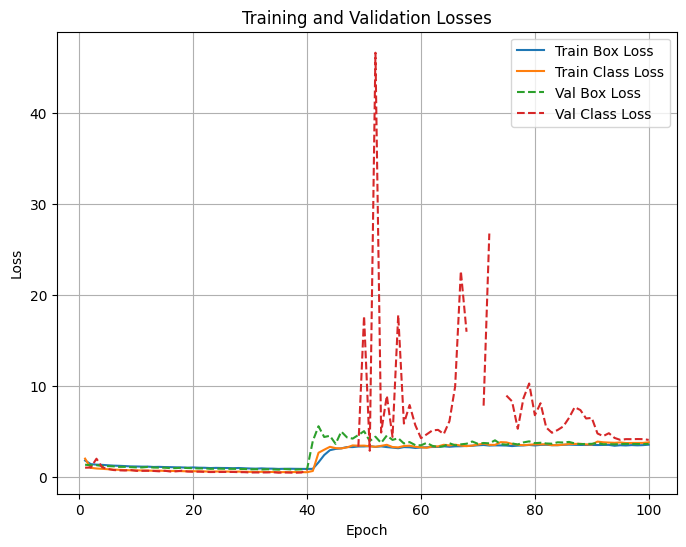

In [59]:
%matplotlib inline
# Load the results CSV file
results_path = "runs/detect/train4/results.csv"
results = pd.read_csv(results_path)

# Plot training and validation losses
plt.figure(figsize=(8, 6))

# Training losses
plt.plot(results["epoch"], results["train/box_loss"], label="Train Box Loss", linestyle="-")
plt.plot(results["epoch"], results["train/cls_loss"], label="Train Class Loss", linestyle="-")

# Validation losses
plt.plot(results["epoch"], results["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(results["epoch"], results["val/cls_loss"], label="Val Class Loss", linestyle="--")

# Add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()

In [68]:
# visualizing test images with predictions
test_images_dir = "./content/drive/MyDrive/SRIP 2025/datasets/data_processed/images/test/"
test_labels_dir = "./content/drive/MyDrive/SRIP 2025/datasets/data_processed/labels/test/"

# Get test image filenames
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".tif")]
# Shuffle for randomness
random.shuffle(test_images)

# Define class colors (for GT and predictions)
GT_COLOR = "blue"
PRED_COLOR = "red"
CLASS_NAMES = ["solar_panel-high", "solar_panel-med", "solar_panel-low"]

def draw_boxes(ax, boxes, color, label_prefix=""):
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert normalized to pixel coordinates
        x1 = (x_center - width / 2) * img_w
        y1 = (y_center - height / 2) * img_h
        box_w = width * img_w
        box_h = height * img_h

        # Create rectangle patch
        rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)

        # Add label text
        label = f"{label_prefix}{CLASS_NAMES[int(class_id)]}"
        ax.text(x1, y1 - 5, label, color=color, fontsize=5, bbox=dict(facecolor="white", alpha=0.7))

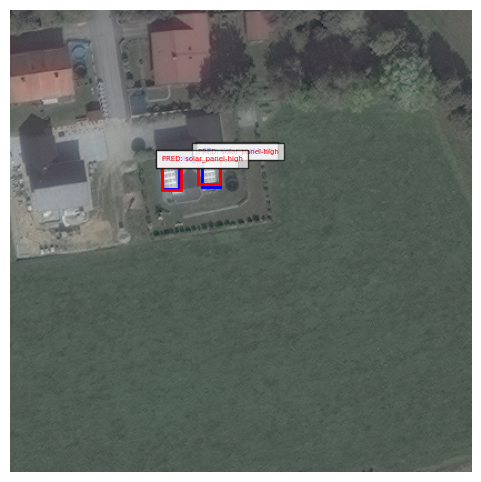

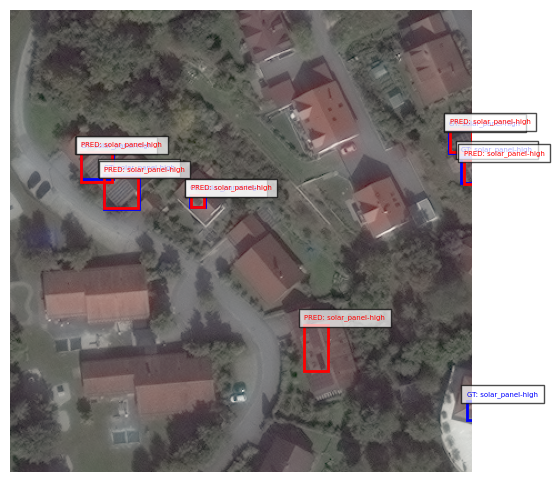

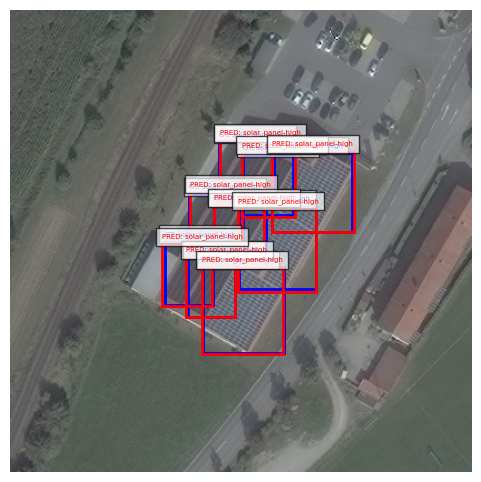

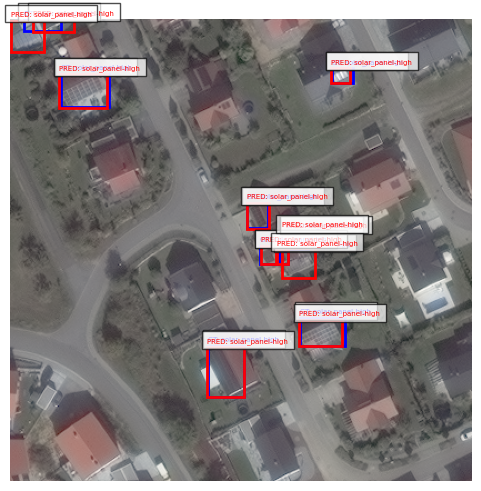

In [69]:
# Process 3-4 random test images
for img_file in test_images[:4]:
    img_path = os.path.join(test_images_dir, img_file)
    label_path = os.path.join(test_labels_dir, img_file.replace(".tif", ".txt"))

    # Load image using PIL
    image = Image.open(img_path)
    img_w, img_h = image.size

    # Load ground truth labels
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                gt_boxes.append(list(map(float, line.strip().split())))

    # Run YOLO prediction
    results = model(img_path, verbose=False)
    # Get predictions in YOLO format
    pred_boxes = results[0].boxes.xywhn.cpu().numpy()
    # Get class predictions
    pred_classes = results[0].boxes.cls.cpu().numpy()

    # Combine predicted boxes with class labels
    pred_boxes = [[pred_class] + list(pred_box) for pred_box, pred_class in zip(pred_boxes, pred_classes)]

    # Plot image with bounding boxes
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image)
    ax.axis("off")

    # Draw ground truth and predicted boxes
    draw_boxes(ax, gt_boxes, GT_COLOR, label_prefix="GT: ")
    draw_boxes(ax, pred_boxes, PRED_COLOR, label_prefix="PRED: ")

    # Show the image with bounding boxes
    plt.show()

In [80]:
def get_all_metrics(test_images):
    # Define thresholds
    iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
    conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

    # Store results in np arrays
    precision_arr = np.zeros((len(iou_thresholds), len(conf_thresholds)))
    recall_arr = np.zeros((len(iou_thresholds), len(conf_thresholds)))
    f1_arr = np.zeros((len(iou_thresholds), len(conf_thresholds)))

    # Process all test images
    total_gt_boxes = []
    total_pred_boxes = []
    total_pred_scores = []
    total_gt_classes = []
    total_pred_classes = []

    for img_file in test_images:
        img_path = os.path.join(test_images_dir, img_file)
        label_path = os.path.join(test_labels_dir, img_file.replace(".tif", ".txt"))

        # Load image to get dimensions
        image = Image.open(img_path)
        img_w, img_h = 416, 416

        # Load ground truth labels
        gt_boxes_yolo = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    gt_boxes_yolo.append(list(map(float, line.strip().split())))

        # Convert ground truth boxes to xyxy format
        img_gt_boxes = []
        img_gt_classes = []
        for box in gt_boxes_yolo:
            class_id, x_center, y_center, width, height = box
            x1, y1, x2, y2 = convert_yolo_corner(x_center, y_center, width, height, img_w, img_h)
            img_gt_boxes.append([x1, y1, x2, y2])
            img_gt_classes.append(int(class_id))

        # Run YOLO prediction
        results = model(img_path)
        pred_boxes = results[0].boxes.xyxy.cpu().numpy()
        pred_scores = results[0].boxes.conf.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy().astype(int)

        # Store detections for this image
        total_gt_boxes.extend(img_gt_boxes)
        total_gt_classes.extend(img_gt_classes)
        total_pred_boxes.extend(pred_boxes)
        total_pred_scores.extend(pred_scores)
        total_pred_classes.extend(pred_classes)

    # Calculate metrics for each combination of thresholds
    for i, iou_threshold in tqdm(enumerate(iou_thresholds)):
        for j, conf_threshold in tqdm(enumerate(conf_thresholds)):
            # Only consider a prediction if confidence is above threshold
            filtered_indices = [i for i, score in enumerate(total_pred_scores) if score >= conf_threshold]
            filtered_pred_boxes = [total_pred_boxes[i] for i in filtered_indices]
            filtered_pred_classes = [total_pred_classes[i] for i in filtered_indices]

            tp = 0
            fp = 0
            gt_matched = [False] * len(total_gt_boxes)

            # Match predictions to ground truth
            for pred_idx, pred_box in enumerate(filtered_pred_boxes):
                pred_class = filtered_pred_classes[pred_idx]

                # Find best matching ground truth box
                best_iou = 0
                best_gt_idx = -1

                for gt_idx, gt_box in enumerate(total_gt_boxes):
                    if gt_matched[gt_idx]:
                        continue  # Skip already matched ground truth boxes

                    # Calculate IoU
                    gt_class = total_gt_classes[gt_idx]
                    if pred_class == gt_class:  # Only match if same class
                        iou = get_iou_xyxy(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx

                # Determine if it's a true positive
                if best_iou >= iou_threshold and best_gt_idx != -1:
                    tp += 1
                    gt_matched[best_gt_idx] = True
                else:
                    fp += 1

            # Count false negatives
            fn = sum(1 for matched in gt_matched if not matched)

            # Calculate precision, recall, F1
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            # Store in arrays
            precision_arr[i, j] = precision
            recall_arr[i, j] = recall
            f1_arr[i, j] = f1


    precision_df = pd.DataFrame(precision_arr, index=iou_thresholds, columns=conf_thresholds)
    recall_df = pd.DataFrame(recall_arr, index=iou_thresholds, columns=conf_thresholds)
    f1_df = pd.DataFrame(f1_arr, index=iou_thresholds, columns=conf_thresholds)

    return precision_df, recall_df, f1_df

In [81]:
# Function to visualize metrics as heatmaps
def plot_metrics_heatmaps(precision_df, recall_df, f1_df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Convert DataFrames to numpy arrays to ensure they're float type
    precision_array = precision_df.values.astype(float)
    recall_array = recall_df.values.astype(float)
    f1_array = f1_df.values.astype(float)

    # Create heatmaps with numpy arrays
    sns.heatmap(precision_array, annot=True, cmap="Blues", ax=axes[0], vmin=0, vmax=1, fmt=".3f",
                xticklabels=precision_df.columns, yticklabels=precision_df.index)
    axes[0].set_title("Precision by IoU and Confidence Thresholds")
    axes[0].set_xlabel("Confidence Threshold")
    axes[0].set_ylabel("IoU Threshold")

    sns.heatmap(recall_array, annot=True, cmap="Greens", ax=axes[1], vmin=0, vmax=1, fmt=".3f",
                xticklabels=recall_df.columns, yticklabels=recall_df.index)
    axes[1].set_title("Recall by IoU and Confidence Thresholds")
    axes[1].set_xlabel("Confidence Threshold")
    axes[1].set_ylabel("IoU Threshold")

    sns.heatmap(f1_array, annot=True, cmap="Reds", ax=axes[2], vmin=0, vmax=1, fmt=".3f",
                xticklabels=f1_df.columns, yticklabels=f1_df.index)
    axes[2].set_title("F1 Score by IoU and Confidence Thresholds")
    axes[2].set_xlabel("Confidence Threshold")
    axes[2].set_ylabel("IoU Threshold")

    plt.tight_layout()
    plt.savefig("metrics_heatmaps.png")
    plt.show()

In [82]:
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [83]:
len(test_images)

255

Calculating metrics for different thresholds...

image 1/1 /content/drive/MyDrive/SRIP 2025/datasets/data_processed/images/test/solarpanels_native_3__x0_8747_y0_10580_dxdy_416.tif: 416x416 2 solar_panel-highs, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/drive/MyDrive/SRIP 2025/datasets/data_processed/images/test/solarpanels_native_1__x0_9119_y0_10931_dxdy_416.tif: 416x416 6 solar_panel-highs, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/drive/MyDrive/SRIP 2025/datasets/data_processed/images/test/solarpanels_native_3__x0_5170_y0_14563_dxdy_416.tif: 416x416 9 solar_panel-highs, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/drive/MyDrive/SRIP 2025/datasets/data_processed/images/test/solarpanels_native_1__x0_1081_y0_6362_dxdy_416.tif: 416x416 11 solar_panel

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.68it/s]
2it [00:00,  5.37it/s]
3it [00:00,  5.41it/s]
5it [00:00,  6.93it/s]
1it [00:00,  1.38it/s]
0it [00:00, ?it/s]
1it [00:00,  6.28it/s]
2it [00:00,  6.30it/s]
3it [00:00,  6.03it/s]
5it [00:00,  7.67it/s]
2it [00:01,  1.46it/s]
0it [00:00, ?it/s]
1it [00:00,  5.54it/s]
2it [00:00,  5.99it/s]
3it [00:00,  6.17it/s]
5it [00:00,  7.58it/s]
3it [00:02,  1.48it/s]
0it [00:00, ?it/s]
1it [00:00,  5.24it/s]
2it [00:00,  4.27it/s]
3it [00:00,  3.97it/s]
5it [00:00,  5.10it/s]
4it [00:03,  1.25it/s]
0it [00:00, ?it/s]
1it [00:00,  2.62it/s]
2it [00:00,  2.66it/s]
3it [00:01,  2.78it/s]
5it [00:01,  3.65it/s]
5it [00:04,  1.13it/s]



Precision Table:
       0.1    0.3    0.5    0.7  0.9
0.1  0.844  0.852  0.860  0.974  1.0
0.3  0.844  0.852  0.860  0.974  1.0
0.5  0.828  0.852  0.860  0.974  1.0
0.7  0.781  0.803  0.807  0.947  1.0
0.9  0.453  0.475  0.491  0.658  1.0

Recall Table:
       0.1    0.3    0.5    0.7    0.9
0.1  0.931  0.897  0.845  0.638  0.069
0.3  0.931  0.897  0.845  0.638  0.069
0.5  0.914  0.897  0.845  0.638  0.069
0.7  0.862  0.845  0.793  0.621  0.069
0.9  0.500  0.500  0.483  0.431  0.069

F1 Score Table:
       0.1    0.3    0.5    0.7    0.9
0.1  0.885  0.874  0.852  0.771  0.129
0.3  0.885  0.874  0.852  0.771  0.129
0.5  0.869  0.874  0.852  0.771  0.129
0.7  0.820  0.824  0.800  0.750  0.129
0.9  0.475  0.487  0.487  0.521  0.129

Creating heatmap visualizations...


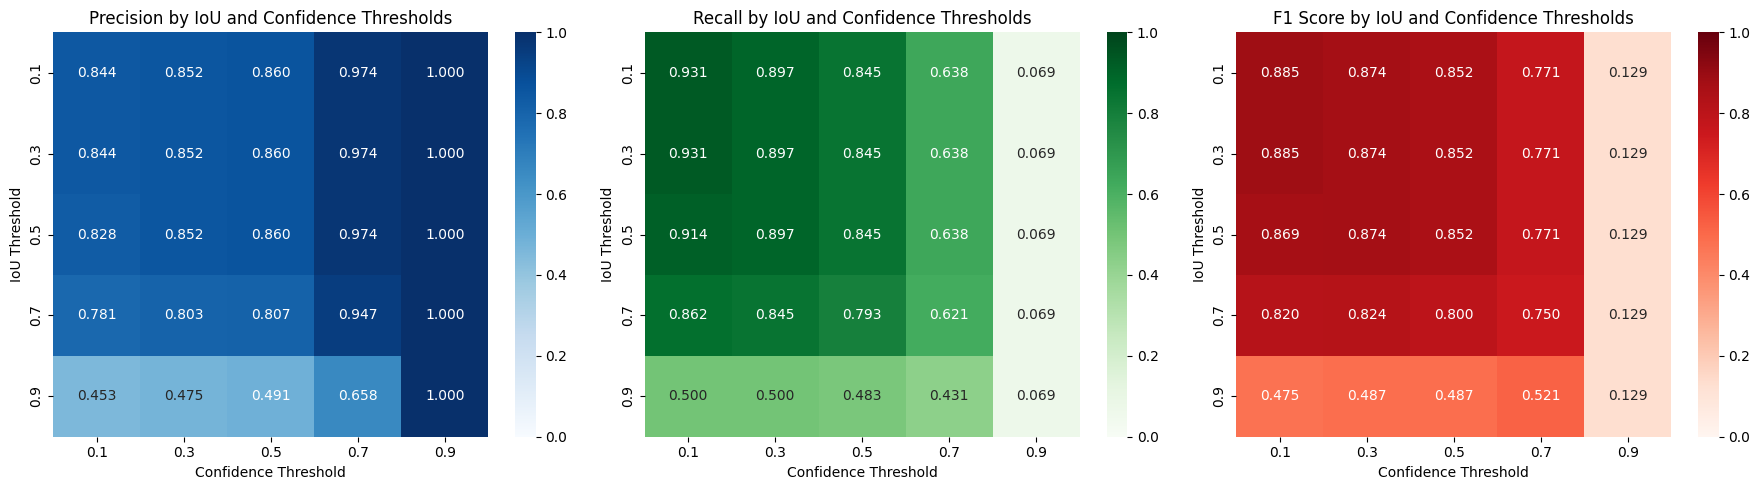

In [84]:
# Calculate metrics
print("Calculating metrics for different thresholds...")
precision_df, recall_df, f1_df = get_all_metrics(test_images[:10])

# Display tables
print()
print("Precision Table:")
print(precision_df.round(3))

print()
print("Recall Table:")
print(recall_df.round(3))

print()
print("F1 Score Table:")
print(f1_df.round(3))

# Plot heatmaps
print()
print("Creating heatmap visualizations...")
plot_metrics_heatmaps(precision_df, recall_df, f1_df)